In [177]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import stats

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### create UDFs

In [2]:
# Create Data audit Report for continuous variables
def continuous_summary(x):
    return pd.Series([x.count(), x.isna().sum(), x.isna().sum()*100/x.isna().count(), x.nunique(), 
                      x.sum(), x.mean(), x.median(), x.std(), 
                      x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.1), x.quantile(0.25), x.quantile(0.5), 
                      x.quantile(0.75), x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max()],
            index = ['N', 'NMISS', '% NMISS', 'UNIQUES', 'SUM', 'MEAN', 'MEDIAN', 'STD', 
                     'MIN', 'P1','P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [3]:
# Create Data audit Report for categorical variables
def categorical_summary(x):
    Mode = x.value_counts().sort_values(ascending = False).reset_index()[0:1]
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [4]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

In [5]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = False)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### Data Importing & Merging of Datasets to get the final output

In [6]:
# Writing output data into excel
output = pd.ExcelWriter('walmart_sales_output.xlsx')

In [348]:
# Load the data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
features = pd.read_csv('data/features.csv')

In [349]:
# Mergeing Datasets
train = train.merge(stores, how='left').merge(features, how='left')
test = test.merge(stores, how='left').merge(features, how='left')

In [350]:
# Combining train and test data to ensure that all the preprocessing and data cleaning
# operations are applied consistently
train['Split'] = 'Train'
test['Split'] = 'Test'
df = pd.concat([train, test], ignore_index=True)

In [320]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Split
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,Train
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,Train
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,Train
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,Train
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,Train


In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536634 entries, 0 to 536633
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         536634 non-null  int64  
 1   Dept          536634 non-null  int64  
 2   Date          536634 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     536634 non-null  bool   
 5   Type          536634 non-null  object 
 6   Size          536634 non-null  int64  
 7   Temperature   536634 non-null  float64
 8   Fuel_Price    536634 non-null  float64
 9   MarkDown1     265596 non-null  float64
 10  MarkDown2     197685 non-null  float64
 11  MarkDown3     242326 non-null  float64
 12  MarkDown4     237143 non-null  float64
 13  MarkDown5     266496 non-null  float64
 14  CPI           498472 non-null  float64
 15  Unemployment  498472 non-null  float64
 16  Split         536634 non-null  object 
dtypes: bool(1), float64(10), int64(3), object(3)
mem

### EDA

In [351]:
# Converting True & False in 'Isholday' column to int i.e 1 and 0
df['IsHoliday'] = df['IsHoliday'].astype('int32')

In [352]:
# Changed the Date column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

In [353]:
# Dummy variables: Dates
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.week

In [218]:
df.select_dtypes(include=np.number).apply(continuous_summary).T.round(1)

,N,NMISS,% NMISS,UNIQUES,SUM,MEAN,MEDIAN,STD,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
Store,536634.0,0.0,0.0,45.0,1.191790e+07,22.2,22.0,12.8,1.0,1.0,3.0,5.0,11.0,22.0,33.0,40.0,43.0,45.0,45.0
Dept,536634.0,0.0,0.0,81.0,2.376070e+07,44.3,37.0,30.5,1.0,1.0,4.0,7.0,18.0,37.0,74.0,92.0,95.0,98.0,99.0
Weekly_Sales,421570.0,115064.0,21.4,359464.0,6.737219e+09,15981.3,7612.0,22711.2,-4988.9,5.0,60.0,291.1,2079.6,7612.0,20205.9,42845.7,61202.0,106479.6,693099.4
IsHoliday,536634.0,0.0,0.0,2.0,3.858900e+04,0.1,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
Size,536634.0,0.0,0.0,40.0,7.334636e+10,136678.6,140167.0,61007.7,34875.0,34875.0,39690.0,39910.0,93638.0,140167.0,202505.0,204184.0,206302.0,219622.0,219622.0
Temperature,536634.0,0.0,0.0,4178.0,3.153893e+07,58.8,60.1,18.7,-7.3,16.9,26.5,32.8,45.2,60.1,73.2,82.8,86.8,92.4,102.0
Fuel_Price,536634.0,0.0,0.0,1011.0,1.829015e+06,3.4,3.5,0.4,2.5,2.6,2.7,2.8,3.0,3.5,3.7,3.9,4.0,4.2,4.5
MarkDown1,265596.0,271038.0,50.5,4023.0,1.975504e+09,7438.0,5126.5,9411.3,-2781.4,18.2,164.0,403.3,2114.6,5126.5,9303.8,15308.1,22494.6,53311.9,103185.0
MarkDown2,197685.0,338949.0,63.2,2715.0,6.937310e+08,3509.3,385.3,8992.0,-265.8,0.0,3.0,10.8,72.5,385.3,2392.4,8762.3,18632.1,47382.7,104519.5
MarkDown3,242326.0,294308.0,54.8,2885.0,4.502208e+08,1857.9,40.8,11616.1,-179.3,0.1,0.8,2.0,7.2,40.8,174.3,573.9,1330.5,76741.0,149483.3


In [219]:
df.select_dtypes(include=['object', 'bool']).apply(categorical_summary)

,Type,Split
N,536634,536634
NMISS,0,0
MODE,A,Train
FREQ,274191,421570
PERCENT,51.09,78.56


In [354]:
df['Store']=df['Store'].astype('str')
df['Dept']=df['Dept'].astype('str')
df['Week']=df['Week'].astype('str')

### Outlier Treatment 

In [355]:
# Getting Categorical and continuous variables
# Date is not included
categorical = ['Store','Dept','IsHoliday','Type','Year','Month','Week']
continuous = ['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment','Size','MarkDown1','MarkDown2','MarkDown3',
              'MarkDown4','MarkDown5']

In [356]:
df[continuous] = df[continuous].apply(lambda x: x.clip(lower = x.dropna().quantile(0.01),
                                                       upper = x.dropna().quantile(0.99)))

### Missing Values Treatment 

In [357]:
# percentage of missing value
df.loc[:, df.isna().sum()>0].isna().sum()*100/df.shape[0]

Weekly_Sales    21.441802
MarkDown1       50.507049
MarkDown2       63.162043
MarkDown3       54.843338
MarkDown4       55.809173
MarkDown5       50.339337
CPI              7.111365
Unemployment     7.111365
dtype: float64

#### Imputing with store dept level

In [358]:
# Treating Missing values in CPI and Unemployment with mean by Store and Department wise
df['CPI'] = df.groupby(['Store','Dept'])['CPI'].transform(lambda x: x.fillna(x.mean()) 
                                                          if x.mean()>0 else x.fillna(df.CPI.mean()))

df['Unemployment'] = df.groupby(['Store','Dept'])['Unemployment'].transform(lambda x: 
                                                       x.fillna(x.mean()) if x.mean()>0 else x.fillna(df.Unemployment.mean()))

In [359]:
# Imputing negative values in MarkDown's as missing if any
markdown = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
df[markdown] = df[markdown].where(df[markdown]>0,0)
df[markdown] = df[markdown].fillna(0)

In [360]:
# percentage of missing value
df.loc[:,df.columns.difference(['Weekly_Sales'])].isna().sum()

CPI             0
Date            0
Dept            0
Fuel_Price      0
IsHoliday       0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
Month           0
Size            0
Split           0
Store           0
Temperature     0
Type            0
Unemployment    0
Week            0
Year            0
dtype: int64

## Visualisation

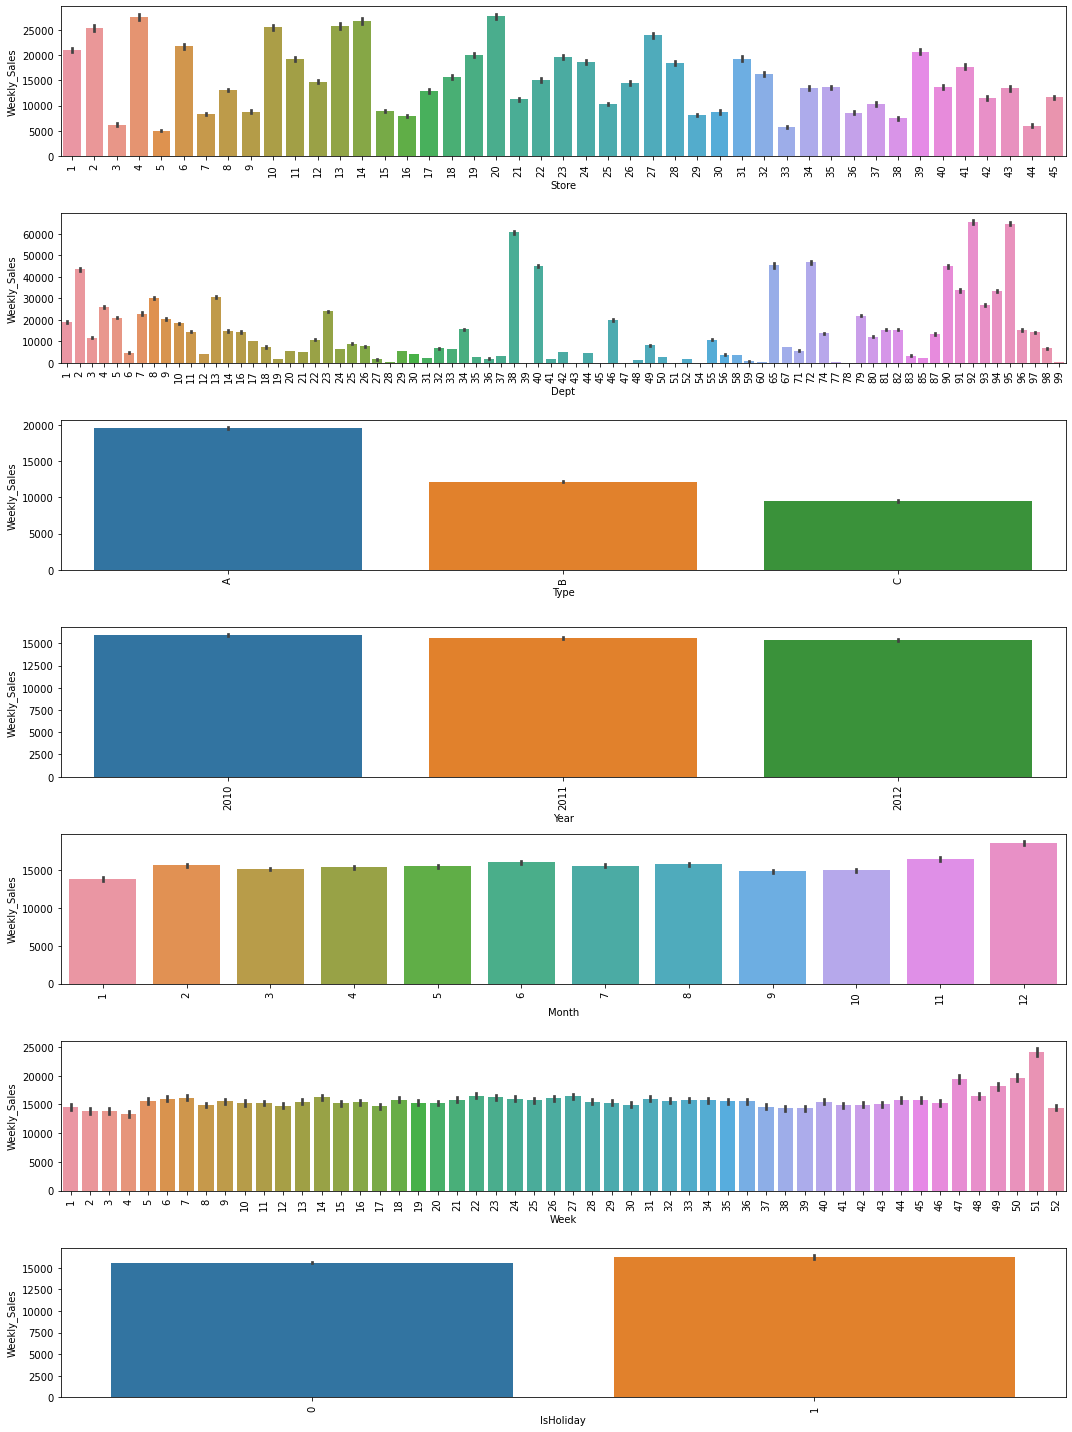

In [39]:
# Visualizing Weekly Sales across different categorical features
plt_cols = ['Store','Dept','Type','Year','Month','Week','IsHoliday'] 
train_ = df[df.Split=='Train']

plt.figure(figsize = (15,20))
for i, col in enumerate(plt_cols):
    plt.subplot(7, 1, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.barplot(x = train_[col], y = train_.Weekly_Sales)
    plt.xticks(rotation = 90)
    plt.tight_layout()

#### Observations
- There is a significant fluctuation in sales depending on the Store, Department and Store type.
- Various combinations of these 3 categorical features would be interesting to observe but the high cardinality stands in the way.
- During the month of november and december, the weekly sales has increased, which is clearly a consequence of the two major holidays - Thanksgiving & Christmas.
- weekly sales peak in major holiday weeks 47 and 51 in particular, with some influencce on the neighbouring or preceeding weeks as well.
- During the holidays the sales are higher on average.

#### Actions
- Since the significance of Store, Department and Store type can't just be tossed, it could be an affective technique to further group them based on sales to be used as ordinal variables.
- Trying to figure out a way to provide some weight to the weeks surrounding the holidays.

In [300]:
# a simple vialisation after grouping values in a feature column based on the corresponding weekly sales

# def cut_cat(cat, bins):
#     grp = train_.groupby(cat)['Weekly_Sales'].mean()
#     cut = pd.cut(grp, bins, labels=False)
#     cuts = pd.DataFrame({'Sales': grp, 'Cut': cut}).groupby('Cut').mean()
#     cuts.plot.line();
#     return cuts.sort_values(by='Cut')

In [361]:
# grouping values in a feature column based on the corresponding weekly sales

def map_cut_str(cat, bins):
    grp = train_.groupby(cat)['Weekly_Sales'].mean()
    cut = pd.cut(grp, bins, labels=False)
    cuts = pd.DataFrame({'Sales': grp, 'Cut': cut})
    dict_zip=dict(zip(list(cuts.index),list(cuts.Cut.astype('str'))))
    col=cat+'_cut'
    df.loc[:,col]=df[cat].map(dict_zip)

In [362]:
# assigning integer values to a feature column to achieve linearity with Weekly Sales

def map_cut_int(cat, bins):
    grp = train_.groupby(cat)['Weekly_Sales'].mean()
    cut = pd.cut(grp, bins, labels=False)
    cuts = pd.DataFrame({'Sales': grp, 'Cut': cut})
    dict_zip=dict(zip(list(cuts.index),list(cuts.Cut)))
    col=cat+'_cut'
    df.loc[:,col]=df[cat].map(dict_zip)

In [363]:
train_ = df[df.Split=='Train']
test_ = df[df.Split=='Test']
# cutting Store into 10 groups
map_cut_str('Store', 20)
# cutting Dept into 20 groups
map_cut_str('Dept', 40)
df.loc[:,'Store_Dept_Type']=df['Store_cut']+'_'+df['Dept_cut']+'_'+df['Type']
train_ = df[df.Split=='Train']
test_ = df[df.Split=='Test']
print('Unique values in train: ', train_['Store_Dept_Type'].nunique())
print('Unique values in test: ', test_['Store_Dept_Type'].nunique())
train_set = set(list(train_['Store_Dept_Type'].unique()))
test_set = set(list(test_['Store_Dept_Type'].unique()))
print('Values in test, not present in train: ', test_set.difference(train_set))

Unique values in train:  711
Unique values in test:  711
Values in test, not present in train:  set()


In [364]:
map_cut_int('Store_Dept_Type', 1000)
map_cut_int('Week', 5)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Split,Year,Month,Week,Store_cut,Dept_cut,Store_Dept_Type,Store_Dept_Type_cut,Week_cut
0,1,1,2010-02-05,24924.50,0,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,Train,2010,2,5,14,11,14_11_A,293,1
1,1,1,2010-02-12,46039.49,1,A,151315,38.51,2.572,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,Train,2010,2,6,14,11,14_11_A,293,1
2,1,1,2010-02-19,41595.55,0,A,151315,39.93,2.572,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,Train,2010,2,7,14,11,14_11_A,293,1
3,1,1,2010-02-26,19403.54,0,A,151315,46.63,2.572,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,Train,2010,2,8,14,11,14_11_A,293,0
4,1,1,2010-03-05,21827.90,0,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,Train,2010,3,9,14,11,14_11_A,293,1


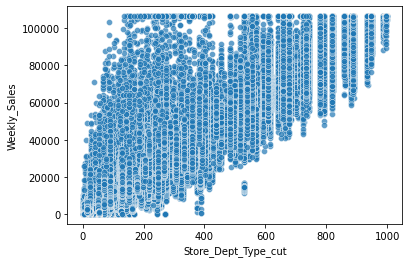

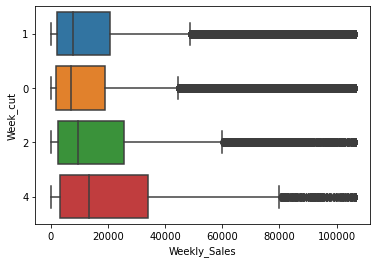

In [365]:
train_ = df[df.Split=='Train']
test_ = df[df.Split=='Test']
sns.scatterplot(x = train_['Store_Dept_Type_cut'], y = train_.Weekly_Sales, alpha=0.70);
plt.show()
sns.boxplot(x=train_['Weekly_Sales'], y=train_['Week_cut'].astype('str'));
plt.show()

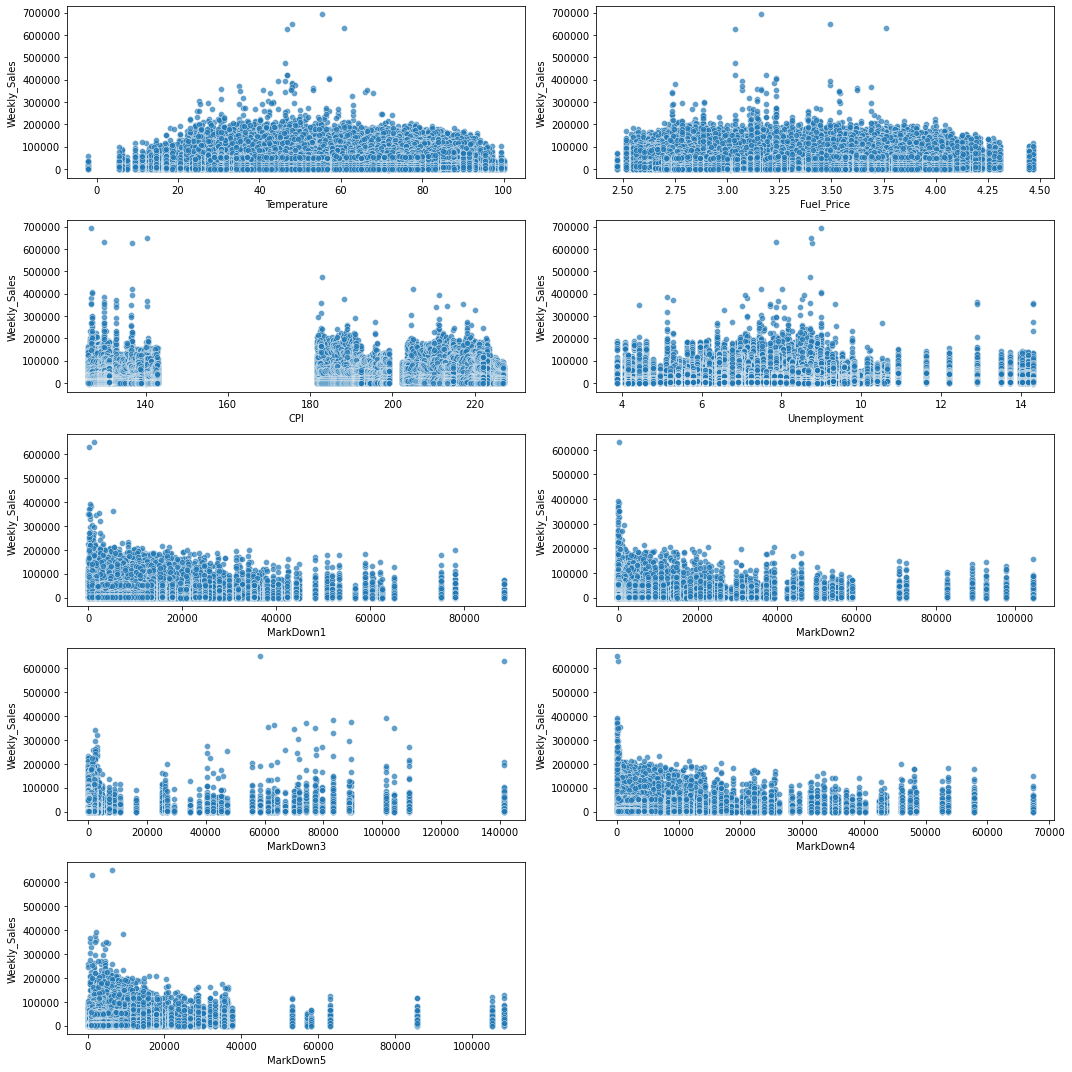

In [18]:
# Visualizing Weekly Sales across different continuous features
plt_cols = ['Temperature','Fuel_Price','CPI','Unemployment','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

plt.figure(figsize = (15,15))
for i, col in enumerate(plt_cols):
    plt.subplot(5, 2, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.scatterplot(x = train_[col], y = train_.Weekly_Sales, alpha=0.70)
    plt.tight_layout() 

#### No significant linearity to be observed here

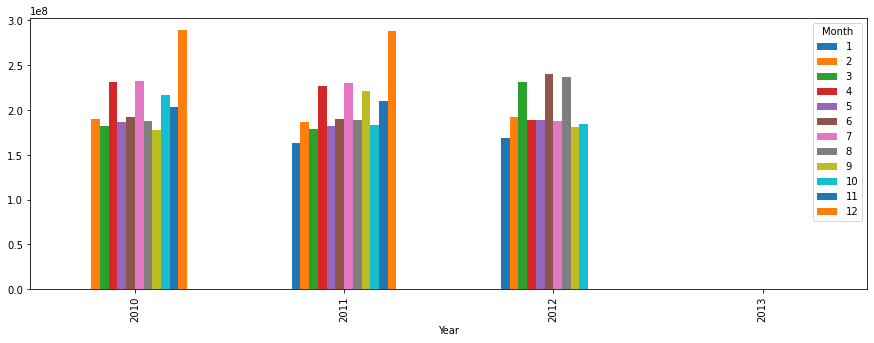

In [19]:
pd.pivot_table(data = train_, index = df.Year, columns= df.Month, 
                values='Weekly_Sales', aggfunc='sum').plot(kind='bar', figsize=(15,5))
plt.show()

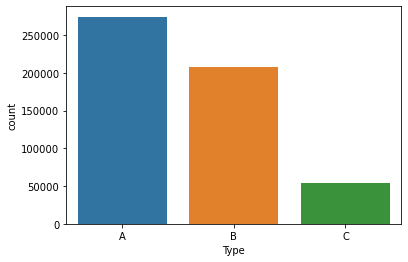

In [20]:
# Numbers of type observation
sns.countplot(train_.Type)
plt.show()

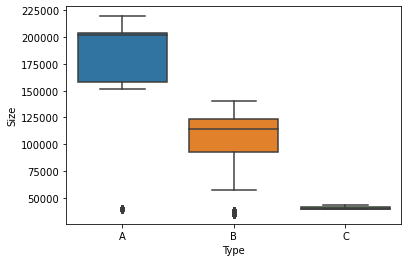

In [21]:
# Size vs Type
sns.boxplot(df.Type,df.Size)
plt.show()

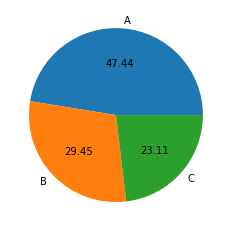

In [119]:
# Mean Weekly Sales by Type
plt.pie(train_.groupby('Type').Weekly_Sales.mean(), labels=train_.Type.unique(), autopct='%.2f')
plt.show()

**By boxplot and piechart, The median of A is the highest and C is the lowest i.e stores with more sizes have higher sales.
There is no overlapped area in size among A, B, and C.**

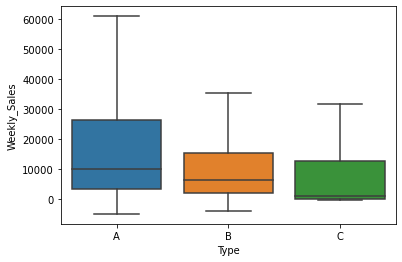

In [23]:
# Weekly Sales by Type
sns.boxplot(df.Type, df.Weekly_Sales, showfliers=False)
plt.show()

**The median of A is the highest and C is the lowest. That means stores with more sizes have higher sales record (The order of median of size and median of sales is the same)**

### Adding new Holidays
#### List of holidays provided to us:
- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [366]:
# Making New Holiday by getting dates of 'Super_Bowl','Labour_Day','Thanksgiving','Christmas'
new_holidays = ['2010-02-12','2011-02-11','2012-02-10','2013-02-08',#Super_Bowl
                '2010-09-10','2011-09-09','2012-09-07','2013-09-06',#Labour_Day
                '2010-11-26','2011-11-25','2012-11-23','2013-11-29',#Thanksgiving
                '2010-12-31','2011-12-30','2012-12-28','2013-12-27']#Christmas

In [ ]:
# SuperBowl = ['2010-02-12','2011-02-11','2012-02-10','2013-02-08']
# train_df['SuperBowl'] = train_df.Date.apply(lambda x: x in SuperBowl).astype('int32')
# test_df['SuperBowl'] = test_df.Date.apply(lambda x: x in SuperBowl).astype('int32')

# LabourDay = ['2010-09-10','2011-09-09','2012-09-07','2013-09-06']
# train_df['LabourDay'] = train_df.Date.apply(lambda x: x in LabourDay).astype('int32')
# test_df['LabourDay'] = test_df.Date.apply(lambda x: x in LabourDay).astype('int32')

# ThanksGiving = pd.to_datetime(['26-Nov-2010', '25-Nov-2011', '23-Nov-2012', '29-Nov-2013'])
# train_df['ThanksGiving'] = train_df.Date.apply(lambda x: x in ThanksGiving).astype('int32')
# test_df['ThanksGiving'] = test_df.Date.apply(lambda x: x in ThanksGiving).astype('int32')

# Christmas = pd.to_datetime(['31-Dec-2010', '30-Dec-2011', '28-Dec-2012', '27-Dec-2013'])
# train_df['Christmas'] = train_df.Date.apply(lambda x: x in Christmas).astype('int32')
# test_df['Christmas'] = test_df.Date.apply(lambda x: x in Christmas).astype('int32')

In [367]:
# Adding new holidays to dataset
df.loc[df.Date.isin(new_holidays), 'IsHoliday'] = 1

### Dummy variables: Categorical Data

In [32]:
# Converting Categorical Variable 'Type' into ordinal Variable 
# type_mapping = {"A": 3, "B": 2, "C": 1}
# df['Type'] = df['Type'].map(type_mapping)

### Log Transformation

In [368]:
# Log Transformation of MarkDown
markdown = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for col in markdown:
    df[col] = df[col].apply(lambda x: np.log(x+1))

### Creating Dependent Y column

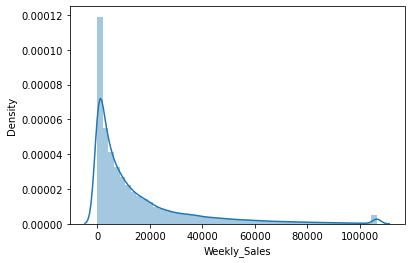

In [369]:
sns.distplot(df.loc[df.Split == 'Train','Weekly_Sales'])
plt.show()

* Deviation from Normal Distribution (Positive Skewness)

In [370]:
print("Skewness of Weekly_Sales is: ", df.loc[df.Split == 'Train','Weekly_Sales'].skew())

Skewness of Weekly_Sales is:  2.2004167042847156


**Log Transformation: -**

In [371]:
df.loc[df.Split == 'Train','Weekly_Sales'].min()

5.0

In [372]:
df.loc[df.Split == 'Train','ln_Weekly_Sales'] = np.log(df.loc[df.Split == 'Train','Weekly_Sales'])

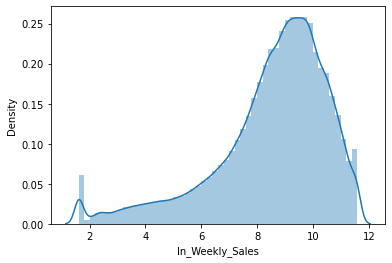

In [373]:
sns.distplot(df.loc[df.Split == 'Train','ln_Weekly_Sales'])
plt.show()

In [374]:
print("Skewness of Weekly_Sales is: ", df.loc[df.Split == 'Train','ln_Weekly_Sales'].skew())

Skewness of Weekly_Sales is:  -1.2118352624018651


### Seprating dataset

In [375]:
train = df.loc[df.Split == 'Train',:]
test = df.loc[df.Split == 'Test',:]

In [376]:
train.drop('Split', axis=1, inplace=True)
test.drop('Split', axis=1, inplace=True)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [43]:
train.to_excel(output,'train', index=False)
test.to_excel(output,'test', index=False)

In [377]:
traindate = train.Date.copy()
testdate = test.Date.copy()

train.drop('Date', axis=1, inplace=True)
test.drop('Date', axis=1, inplace=True,)

In [378]:
train.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week,Store_cut,Dept_cut,Store_Dept_Type,Store_Dept_Type_cut,Week_cut,ln_Weekly_Sales
0,1,1,24924.50,0,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2,5,14,11,14_11_A,293,1,10.123607
1,1,1,46039.49,1,A,151315,38.51,2.572,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,2010,2,6,14,11,14_11_A,293,1,10.737255


In [379]:
test.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week,Store_cut,Dept_cut,Store_Dept_Type,Store_Dept_Type_cut,Week_cut,ln_Weekly_Sales
0,1,1,NaN,0,A,151315,55.32,3.386,8.819878,8.546500,3.947776,8.199986,7.915136,223.462779,6.573,2012,11,44,14,11,14_11_A,293,1,NaN
1,1,1,NaN,0,A,151315,61.24,3.314,9.343325,8.123229,3.720378,8.444147,8.725046,223.481307,6.573,2012,11,45,14,11,14_11_A,293,1,NaN


### EDA

In [380]:
continuous = ['ln_Weekly_Sales', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size', 
              'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Store_Dept_Type_cut', 'Week_cut']
categorical = ['Store', 'Dept', 'IsHoliday', 'Type', 'Week']

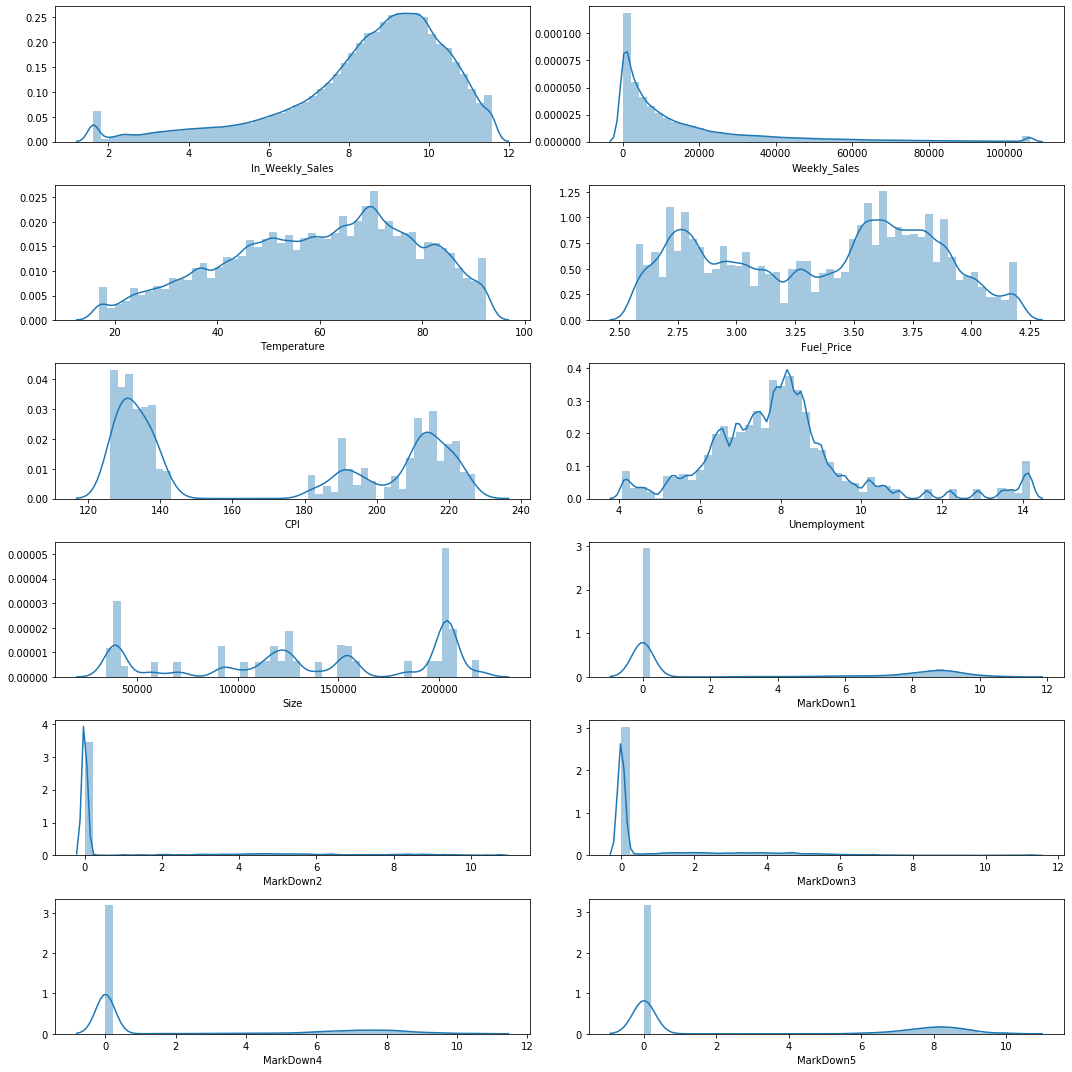

In [48]:
plt.figure(figsize = (15,15))
for i, col in enumerate(continuous):
    plt.subplot(6, 2, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.distplot(train[col])
    plt.tight_layout() 

In [49]:
train[continuous].apply(continuous_summary).T.round(1)

,N,NMISS,% NMISS,UNIQUES,SUM,MEAN,MEDIAN,STD,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
ln_Weekly_Sales,421570.0,0.0,0.0,354230.0,3.585261e+06,8.5,8.9,2.0,1.6,1.6,4.1,5.7,7.6,8.9,9.9,10.7,11.0,11.6,11.6
Weekly_Sales,421570.0,0.0,0.0,354230.0,6.599483e+09,15654.5,7612.0,20781.7,5.0,5.0,60.0,291.1,2079.6,7612.0,20205.9,42845.7,61202.0,106477.7,106479.6
Temperature,421570.0,0.0,0.0,3436.0,2.533285e+07,60.1,62.1,18.3,16.9,18.3,27.3,34.0,46.7,62.1,74.3,83.6,87.3,92.4,92.4
Fuel_Price,421570.0,0.0,0.0,861.0,1.416574e+06,3.4,3.5,0.5,2.6,2.6,2.7,2.7,2.9,3.5,3.7,3.9,4.0,4.2,4.2
CPI,421570.0,0.0,0.0,2138.0,7.217371e+07,171.2,182.3,39.2,126.1,126.1,126.5,128.8,132.0,182.3,212.4,219.4,221.9,225.5,227.2
Unemployment,421570.0,0.0,0.0,347.0,3.355525e+06,8.0,7.9,1.9,4.1,4.2,5.3,6.0,6.9,7.9,8.6,9.8,12.2,14.2,14.2
Size,421570.0,0.0,0.0,40.0,5.764039e+10,136727.9,140167.0,60980.6,34875.0,34875.0,39690.0,39910.0,93638.0,140167.0,202505.0,204184.0,206302.0,219622.0,219622.0
MarkDown1,421570.0,0.0,0.0,2238.0,1.233207e+06,2.9,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,7.9,9.1,9.4,10.2,10.9
MarkDown2,421570.0,0.0,0.0,1464.0,6.100357e+05,1.4,0.0,2.8,0.0,0.0,0.0,0.0,0.0,0.0,1.2,6.1,8.2,10.0,10.8
MarkDown3,421570.0,0.0,0.0,1643.0,4.700637e+05,1.1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.7,4.3,5.4,7.6,11.2


In [50]:
train[categorical].apply(categorical_summary)

,Store,Dept,IsHoliday,Type,Week
N,421570.00,421570.00,421570.00,421570.00,421570.00
NMISS,0.00,0.00,0.00,0.00,0.00
MODE,13.00,1.00,0.00,3.00,7.00
FREQ,10474.00,6435.00,391909.00,215478.00,8929.00
PERCENT,2.48,1.53,92.96,51.11,2.12


### Correlation Matrix

In [51]:
correlation = train.corr()
correlation.to_excel(output, 'correlation')

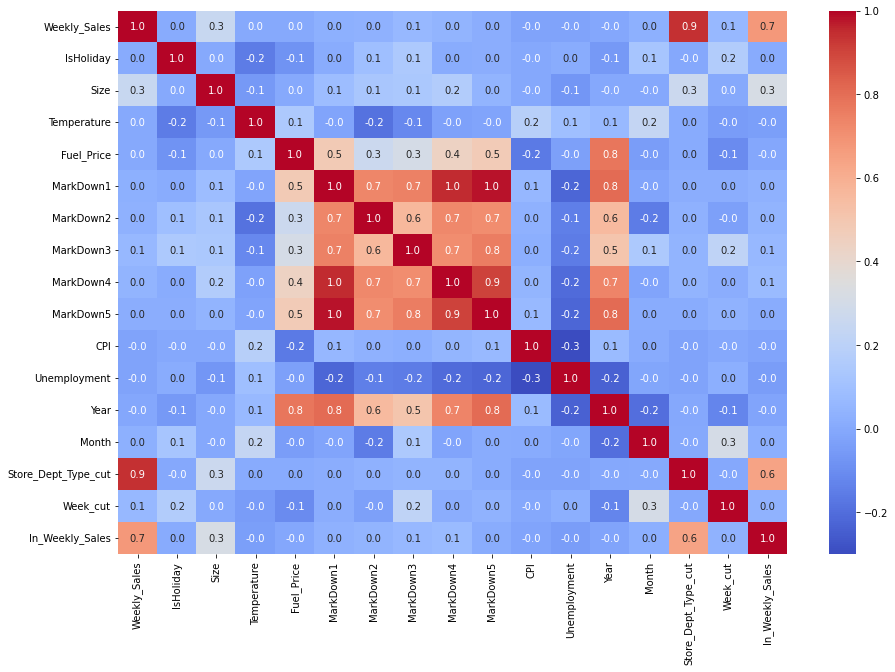

In [381]:
# Plotting correlation between all important features
plt.figure(figsize=(15, 10))
sns.heatmap(train.corr(), cmap='coolwarm', annot=True, fmt=".1f")
plt.show()

In [382]:
# Dropping highly correlated features
features_drop = ['MarkDown1', 'Year'] 
train.drop(features_drop, axis=1, inplace=True)

# Feature Engineering

In [383]:
train.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Month,Week,Store_cut,Dept_cut,Store_Dept_Type,Store_Dept_Type_cut,Week_cut,ln_Weekly_Sales
0,1,1,24924.50,0,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,211.096358,8.106,2,5,14,11,14_11_A,293,1,10.123607
1,1,1,46039.49,1,A,151315,38.51,2.572,0.0,0.0,0.0,0.0,211.242170,8.106,2,6,14,11,14_11_A,293,1,10.737255


## Variance Inflation Factor (VIF)

#### VIF (Variance Inflation Factor): Check the multicollinieirity for all the variables in the model

In [384]:
model_param = 'ln_Weekly_Sales ~ ' + ' + '.join(train.columns.difference(['ln_Weekly_Sales','Weekly_Sales']))
print(model_param)

ln_Weekly_Sales ~ CPI + Dept + Dept_cut + Fuel_Price + IsHoliday + MarkDown2 + MarkDown3 + MarkDown4 + MarkDown5 + Month + Size + Store + Store_Dept_Type + Store_Dept_Type_cut + Store_cut + Temperature + Type + Unemployment + Week + Week_cut


In [386]:
# High VIF means information in that variable has already been explained by other X variables present in the model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# dropped: Month + MarkDown5 + 
model_param = '''ln_Weekly_Sales ~ CPI + Fuel_Price + IsHoliday + MarkDown2 + MarkDown3 + MarkDown4 + 
Size + Temperature + Unemployment + Store_Dept_Type_cut + Week_cut'''

y, X = dmatrices(model_param, data = train, return_type = 'dataframe')

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.sort_values('VIF', ascending=False, inplace=True, ignore_index=True)
vif

,Features,VIF
0,Intercept,152.655402
1,MarkDown4,3.520407
2,MarkDown2,2.333417
3,MarkDown3,2.325105
4,Fuel_Price,1.395473
5,CPI,1.235009
6,Temperature,1.214884
7,Unemployment,1.182294
8,Week_cut,1.142392
9,Size,1.117524


In [387]:
# All the features have less than 4 VIF Factor(low Multicollinearity). using these features for model building.
vif_cols = list(set(vif.Features).difference(['Intercept']))
vif_cols.sort()
print('numbers of selected features: ', len(vif_cols))
print(vif_cols)

numbers of selected features:  11
['CPI', 'Fuel_Price', 'IsHoliday', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'Size', 'Store_Dept_Type_cut', 'Temperature', 'Unemployment', 'Week_cut']


### Linear reggresion

In [388]:
formula_m1 = 'ln_Weekly_Sales ~ ' + ' + '.join(vif_cols)
print(formula_m1)

ln_Weekly_Sales ~ CPI + Fuel_Price + IsHoliday + MarkDown2 + MarkDown3 + MarkDown4 + Size + Store_Dept_Type_cut + Temperature + Unemployment + Week_cut


In [401]:
import statsmodels.formula.api as smf

# dropped: 
formula_m1 = '''ln_Weekly_Sales ~ CPI + Fuel_Price + IsHoliday + MarkDown2 + MarkDown3 + MarkDown4 + 
                Size + Store_Dept_Type_cut + Temperature + Unemployment + Week_cut'''

model1 = smf.ols(formula_m1, data=train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:        ln_Weekly_Sales   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                 2.994e+04
Date:                Wed, 28 Sep 2022   Prob (F-statistic):               0.00
Time:                        09:22:47   Log-Likelihood:            -7.7815e+05
No. Observations:              421570   AIC:                         1.556e+06
Df Residuals:                  421558   BIC:                         1.556e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.3222    

**Analysis of Residuals**

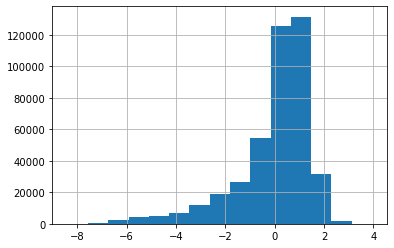

In [402]:
# Checking Errors distribution
model1.resid.hist(bins=15)
plt.show()
# Residuals following Normal distribution. This is one of the Assumption in Linear Regression.

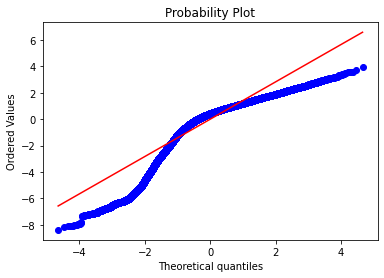

In [403]:
# Q-Q plot of Residuals
from scipy import stats
import pylab
stats.probplot(model1.resid, dist='norm', plot=pylab)
pylab.show()

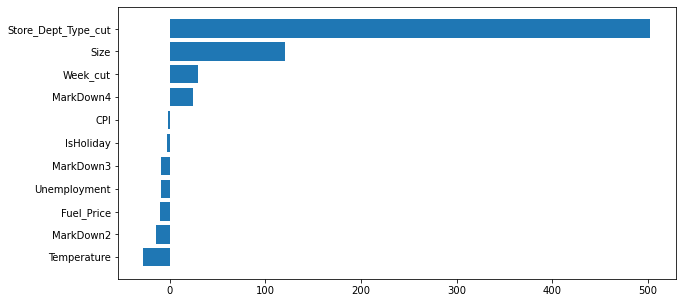

In [404]:
# Getting importance of factors
lr_fi = pd.DataFrame({'Features' : model1.tvalues[1:].index,
                      'T_value' : model1.tvalues[1:]
                     }).sort_values(by = 'T_value').reset_index(drop = True)

lr_fi.to_excel(output, 'Drivers', startrow=2, startcol=0, index = False)

plt.figure(figsize=(10,5))
plt.barh(width = lr_fi.T_value, y = lr_fi.Features)
plt.show()

# Machine learning

#### Getting Train and Test dataset for Machine Learning modelling

In [405]:
# Getting final features
final_selected = model1.pvalues.index.difference(['Intercept'])
print('final features : ',final_selected)
X = train[final_selected]
Y = train.ln_Weekly_Sales

final features :  Index(['CPI', 'Fuel_Price', 'IsHoliday', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'Size', 'Store_Dept_Type_cut', 'Temperature', 'Unemployment',
       'Week_cut'],
      dtype='object')


In [406]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [407]:
# dataframe for train and test output
train_output = pd.DataFrame()
test_output = pd.DataFrame()

# Including the Y(dependent) Variable to compare
train_output['Weekly_Sales'] = np.exp(train_y)
test_output['Weekly_Sales'] = np.exp(test_y)

# MODELS

In [431]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRFRegressor
from sklearn import svm

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold, cross_validate, RepeatedKFold
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, classification_report, mean_squared_error, mean_absolute_error, log_loss)

In [428]:
# Different models
models = []
models.append(('LinearRegression', LinearRegression()))
models.append(('DecisionTreeRegressor', DecisionTreeRegressor()))
models.append(('RandomForestRegressor', RandomForestRegressor()))
models.append(('ExtraTreeRegressor', ExtraTreeRegressor()))
models.append(('GradientBoostingRegressor', GradientBoostingRegressor()))
models.append(('XGBRFRegressor', XGBRFRegressor()))

In [429]:
# evaluate each model in turn
Model = []
mae=[]
rmse=[]
r2=[]
mape=[]


for name, model in models:
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    scores=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error']
    cv_results = cross_validate(model, train_x, train_y, cv=kfold, n_jobs=-1, scoring=scores) 
    Model.append(name)
    mae.append(cv_results['test_neg_mean_absolute_error'].mean())
    rmse.append(cv_results['test_neg_root_mean_squared_error'].mean())
    r2.append(cv_results['test_r2'].mean())
    mape.append(cv_results['test_neg_mean_absolute_percentage_error'].mean())
    
results=pd.DataFrame({'MAE':mae, 'RMSE':rmse, 'r2':r2, 'MAPE':mape}, index=Model)
results

,MAE,RMSE,r2,MAPE
LinearRegression,-1.106565,-1.531438,0.438928,-0.207073
DecisionTreeRegressor,-0.810137,-1.390717,0.537285,-0.155540
RandomForestRegressor,-0.748964,-1.270030,0.614110,-0.145986
ExtraTreeRegressor,-0.808865,-1.390789,0.537239,-0.155315
GradientBoostingRegressor,-0.634132,-1.072346,0.724898,-0.130192
XGBRFRegressor,-0.637195,-1.071692,0.725233,-0.130241




---



### Saving the output in markdown

|Model|MAE|RMSE|r2|MAPE|
| ----------- | ----------- | ----------- | ----------- | ----------- |
|LinearRegression|-1.106565|-1.531438|0.438928|-0.207073|
|DecisionTreeRegressor|-0.810137|-1.390717|0.537285|-0.155540|
|RandomForestRegressor|-0.748964|-1.270030|0.614110|-0.145986|
|ExtraTreeRegressor|-0.808865|-1.390789|0.537239|-0.155315|
|GradientBoostingRegressor|-0.634132|-1.072346|0.724898|-0.130192|
|XGBRFRegressor|-0.637195|-1.071692|0.725233|-0.130241|

#### Gradient Boosting Regressor seems to perform the best

## Gradient Boosting Regressor

In [435]:
# Model building

# A more rigorous gridsearch as below can be performed depending on time and computational power
# param = {'n_estimators': [10, 50, 100], 
#          'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0],
#          'subsample': [0.5, 0.7, 1.0],
#          'max_depth': [3, 7, 9]
#          }

param = {'n_estimators': [50, 100], 
         'learning_rate' : [0.001, 0.01],
         'max_depth': [9, 11]
         }

gscv_dt = GridSearchCV(GradientBoostingRegressor(random_state=42), 
                        param_grid=param, 
                        cv = 5,
                        scoring = 'neg_mean_squared_error',
                        n_jobs=-1,
                        verbose=5).fit(train_x, train_y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [436]:
gscv_dt.best_params_

{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100}

In [438]:
# best Score
-1*gscv_dt.best_score_

1.5176011400709435

**Building final descision  tree model on best parameters**

In [441]:
gb = gscv_dt.best_estimator_

# Predicting values for both training and testing data sets
train_output.loc[:, 'Gradient_boost_pred'] = np.exp(gb.predict(train_x))
test_output.loc[:, 'Gradient_boost_pred'] = np.exp(gb.predict(test_x))

In [457]:
# Different metrics
Metrics = []
Metrics.append(('Mean_absolute_error', metrics.mean_absolute_error))
Metrics.append(('Mean_squared_error', metrics.mean_squared_error))
Metrics.append(('Root_mean_squared_error', metrics.mean_squared_error))
Metrics.append(('r-squared', metrics.r2_score))
Metrics.append(('Mean_absolute_percentage_error', metrics.mean_absolute_percentage_error))


In [458]:
# evaluate the model with each metric
Metric = []
Train_score=[]
Test_score=[]

for name, metric_ in Metrics:
    Metric.append(name)
    if (name=='Root_mean_squared_error'):
        Train_score.append(np.sqrt(metric_(train_y, train_output.Gradient_boost_pred)))
        Test_score.append(np.sqrt(metric_(test_y, test_output.Gradient_boost_pred)))
    else:
        Train_score.append(metric_(train_y, train_output.Gradient_boost_pred))
        Test_score.append(metric_(test_y, test_output.Gradient_boost_pred))
    
results=pd.DataFrame({'Train':Train_score, 'Test':Test_score}, index=Metric)
pd.options.display.float_format = '{:.4f}'.format
results

,Train,Test
Mean_absolute_error,8018.0088,7991.5009
Mean_squared_error,116791140.4773,116147436.9734
Root_mean_squared_error,10806.9950,10777.1720
r-squared,-27939539.1875,-27710381.6509
Mean_absolute_percentage_error,842.3092,841.4402


**Decile Analysis**

In [460]:
# Creating Deciles
train_output.loc[:,'GB_deciles'] = pd.qcut(train_output['Gradient_boost_pred'], 10, labels = False, duplicates = 'drop')
test_output.loc[:,'GB_deciles'] = pd.qcut(test_output['Gradient_boost_pred'], 10, labels = False, duplicates = 'drop')

# Decile Analysis for train_output data
GB_decile_train = train_output.groupby('GB_deciles')[['Weekly_Sales', 'Gradient_boost_pred']].mean().reset_index().sort_values(
    by = 'GB_deciles')

# Decile Analysis for test_output data
GB_decile_test = test_output.groupby('GB_deciles')[['Weekly_Sales', 'Gradient_boost_pred']].mean().reset_index().sort_values(
    by = 'GB_deciles')

# write the data into the file
GB_decile_train.to_excel(output, 'Decile', startrow=3 , startcol=0, index = False)
GB_decile_test.to_excel(output, 'Decile', startrow=3 , startcol=5, index = False)

In [461]:
GB_decile_train

,GB_deciles,Weekly_Sales,Gradient_boost_pred
0,0,444.2673,554.2267
1,1,1869.0530,1490.6528
2,2,3075.3466,2712.6913
3,3,4347.3669,3631.5405
4,4,6681.3948,4885.1942
5,5,9505.2686,6603.7665
6,6,14036.5607,8853.7784
7,7,20784.7238,11660.5401
8,8,31787.3811,15373.8689
9,9,64172.3939,24528.6219


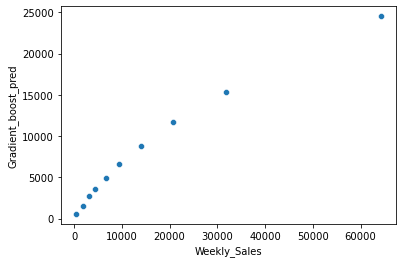

In [463]:
sns.scatterplot(data = GB_decile_train, x='Weekly_Sales', y='Gradient_boost_pred')
plt.show()

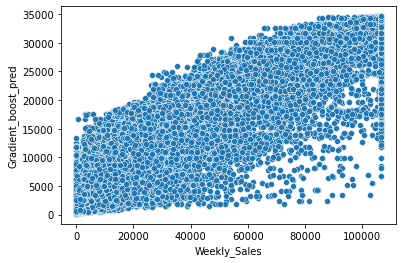

In [473]:
sns.scatterplot(data = train_output, x='Weekly_Sales', y='Gradient_boost_pred')
plt.show()

In [462]:
GB_decile_test

,GB_deciles,Weekly_Sales,Gradient_boost_pred
0,0,460.6012,553.5295
1,1,1916.1932,1491.6467
2,2,3071.1701,2712.7807
3,3,4368.2826,3622.3677
4,4,6613.0826,4863.0015
5,5,9447.7318,6593.7958
6,6,14100.7608,8828.4241
7,7,20710.1656,11598.1979
8,8,31737.9085,15314.0259
9,9,64018.1364,24478.9081


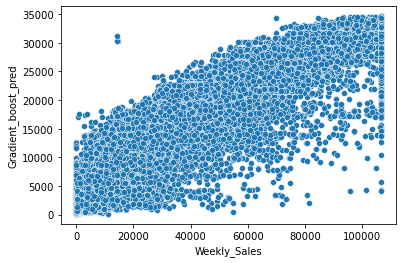

In [474]:
sns.scatterplot(data = test_output, x='Weekly_Sales', y='Gradient_boost_pred')
plt.show()

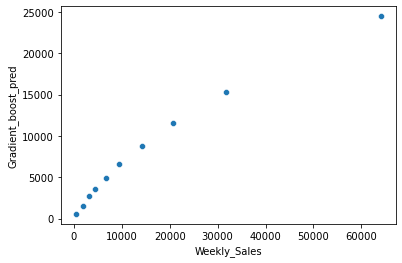

In [464]:
sns.scatterplot(data = GB_decile_test, x='Weekly_Sales', y='Gradient_boost_pred')
plt.show()

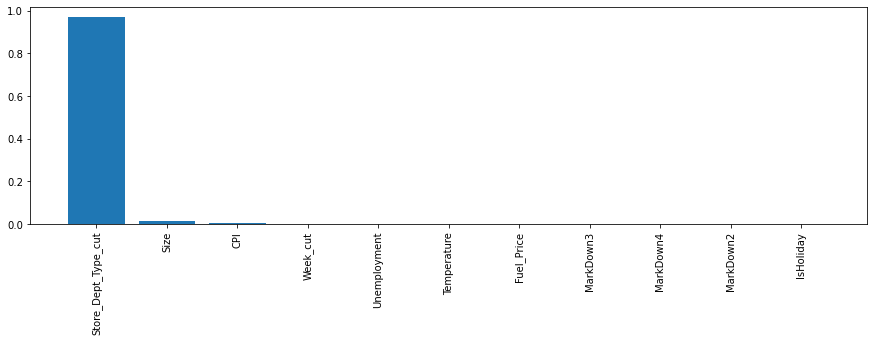

In [466]:
# Getting importance of factors
gb_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : gb.feature_importances_
                     }).sort_values(by = 'Importance', ascending=False).reset_index(drop = True)

gb_fi.to_excel(output, 'Drivers', startrow=2, startcol=5, index = False)
plt.figure(figsize=(15,4))
plt.bar(height = gb_fi.Importance, x = gb_fi.Features)
plt.xticks(rotation = 90)
plt.show()

### Predicting Test Dataset

In [468]:
Final = pd.DataFrame({
             'Id' : test.Store.astype(str)+'_'+test.Dept.astype(str)+'_'+testdate.astype(str),
             'Weekly_Sales' : np.exp(gb.predict(test[final_selected]))
                        })

Final.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,15245.1883
1,1_1_2012-11-09,15245.1883
2,1_1_2012-11-16,15411.0260
3,1_1_2012-11-23,17374.9321
4,1_1_2012-11-30,15245.1883


In [469]:
# Saving prediction on test dataset to excel
Final.to_excel('Final_Submission.xlsx', index = False)

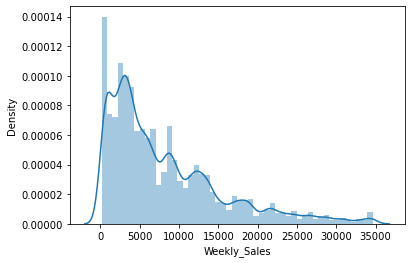

In [470]:
sns.distplot(Final.Weekly_Sales)
plt.show()

In [471]:
Final.loc[:,'deciles'] = pd.qcut(Final['Weekly_Sales'], 10, labels = False, duplicates = 'drop')

# Decile Analysis for test_output data
decile_test = Final.groupby('deciles')[['Weekly_Sales']].mean().reset_index().sort_values(by = 'deciles', ascending = False)
decile_test

,deciles,Weekly_Sales
9,9,24673.8664
8,8,15445.6675
7,7,11664.8354
6,6,8901.0761
5,5,6657.8153
4,4,4958.2277
3,3,3653.0743
2,2,2745.7407
1,1,1533.0890
0,0,569.9114


In [472]:
output.save()